In [ ]:
# ==================================
# 1. Setup & Mount Drive
# ==================================
import os
from google.colab import files

print("Mounting Google Drive...")
from google.colab import drive
drive.mount('/content/drive')

print("\nInstalling required libraries...")
# Install kagglehub (for downloading), transformers (for BERT), and reportlab (for PDF)
!pip install -q kagglehub transformers reportlab

# --- Kaggle API Setup ---
# We still need the Kaggle API key for the *first* download.
if not os.path.exists("/root/.kaggle/kaggle.json"):
    print("\nPlease upload your kaggle.json file (this is needed for the first download):")
    uploaded = files.upload()
    !mkdir -p ~/.kaggle
    !mv kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
else:
    print("\nKaggle API key already exists.")

print("\nSetup complete.")

Mounting Google Drive...
Mounted at /content/drive

Installing required libraries...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 28.5 MB/s eta 0:00:00

Please upload your kaggle.json file (this is needed for the first download):


Saving kaggle.json to kaggle.json

Setup complete.


In [ ]:
# ==================================
# 2. Download Dataset to Google Drive
# ==================================
import kagglehub
import os

# This is the new persistent path in your Google Drive
DRIVE_DATA_DIR = "/content/drive/MyDrive/HAM10000_Dataset/"
DRIVE_META_PATH = os.path.join(DRIVE_DATA_DIR, "HAM10000_metadata.csv")

# Check if the dataset is already in your Drive
if os.path.exists(DRIVE_META_PATH):
    print(f"Dataset already found in Google Drive at: {DRIVE_DATA_DIR}")

else:
    print("Dataset not found in Google Drive. Downloading from Kaggle...")
    # 1. Download from KaggleHub to a temporary Colab path
    temp_download_path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")
    print(f"Dataset downloaded to: {temp_download_path}")

    # 2. Create the destination folder in Google Drive
    os.makedirs(DRIVE_DATA_DIR, exist_ok=True)
    print(f"Created directory in Google Drive: {DRIVE_DATA_DIR}")

    # 3. Copy files from the temporary path to your Google Drive
    print("Copying files to Google Drive... (This may take a few minutes)")

    # Copy metadata and other CSVs
    !cp {temp_download_path}/*.csv {DRIVE_DATA_DIR}

    # Copy all images from the source folders (which are unzipped)
    src_dir1 = os.path.join(temp_download_path, "HAM10000_images_part_1")
    src_dir2 = os.path.join(temp_download_path, "HAM10000_images_part_2")

    !cp {src_dir1}/*.jpg {DRIVE_DATA_DIR}
    !cp {src_dir2}/*.jpg {DRIVE_DATA_DIR}

    print("All files successfully copied to Google Drive for future use.")

print("\n--- Step 2 Complete ---")

Dataset not found in Google Drive. Downloading from Kaggle...


100%|██████████| 5.20G/5.20G [00:37<00:00, 148MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2
Created directory in Google Drive: /content/drive/MyDrive/HAM10000_Dataset/
Copying files to Google Drive... (This may take a few minutes)
All files successfully copied to Google Drive for future use.

--- Step 2 Complete ---


In [ ]:
# ==================================
# 3. Load & Preprocess Data (from Drive) - CORRECTED
# ==================================
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import os

# --- 1. Define Paths ---
DRIVE_DATA_DIR = "/content/drive/MyDrive/HAM10000_Dataset/"
meta_path = os.path.join(DRIVE_DATA_DIR, "HAM10000_metadata.csv")
image_dir = DRIVE_DATA_DIR

print(f"Loading metadata from: {meta_path}")
metadata_df = pd.read_csv(meta_path)

# --- 2. Clean Metadata ---
print("Cleaning metadata...")
metadata_df['age'] = metadata_df['age'].fillna(metadata_df['age'].median())
metadata_df['sex'] = metadata_df['sex'].fillna(metadata_df['sex'].mode()[0])
metadata_df['localization'] = metadata_df['localization'].fillna(metadata_df['localization'].mode()[0])

# --- 3. Create Image Path Map ---
print("Creating image path map...")
image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg')]
image_path_map = {os.path.basename(f).replace('.jpg', ''): f for f in image_files}
metadata_df['image_path'] = metadata_df['image_id'].map(image_path_map)
metadata_df = metadata_df.dropna(subset=['image_path'])

# --- 4. Create Text Metadata (As per your PDF) ---
print("Creating text metadata sentences...")
metadata_df['text_metadata'] = "A lesion from the " + metadata_df['localization'] + \
                               " of a " + metadata_df['age'].astype(int).astype(str) + \
                               " year old " + metadata_df['sex'] + "."

# --- 5. Encode Target Label ---
le = LabelEncoder()
metadata_df['label'] = le.fit_transform(metadata_df['dx'])
num_classes = len(le.classes_)
class_names = list(le.classes_)

# --- 6. Address Class Imbalance ---
print("Balancing dataset (max 600 samples per class)...")
n_samples_per_class = 600

# We no longer need 'include_groups=False'
balanced_df = metadata_df.groupby('label').apply(
    lambda x: x.sample(n=min(len(x), n_samples_per_class), random_state=42)
)

# --- THIS IS THE FIX ---
# Reset the index to turn 'label' from an index back into a column
balanced_df = balanced_df.reset_index(drop=True)
# 'drop=True' prevents the old index from being added as a new column

print(f"\nOriginal data shape: {metadata_df.shape}")
print(f"Balanced subset shape: {balanced_df.shape}")
print("\nBalanced Class Distribution:\n", balanced_df['dx'].value_counts())

# --- 7. Split Data ---
print("\nSplitting data...")
# This will now work because 'label' is a column in 'balanced_df'
train_df, val_df = train_test_split(
    balanced_df,
    test_size=0.2,
    stratify=balanced_df['label'],
    random_state=42
)

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}")
print(f"Total classes: {num_classes}")
print("Classes:", class_names)
print("\nExample text metadata:\n", train_df.iloc[0]['text_metadata'])
print("\n--- Step 3 Complete ---")

Loading metadata from: /content/drive/MyDrive/HAM10000_Dataset/HAM10000_metadata.csv
Cleaning metadata...
Creating image path map...
Creating text metadata sentences...
Balancing dataset (max 600 samples per class)...

Original data shape: (10015, 10)
Balanced subset shape: (2898, 10)

Balanced Class Distribution:
 dx
bkl      600
nv       600
mel      600
bcc      514
akiec    327
vasc     142
df       115
Name: count, dtype: int64

Splitting data...
Train size: 2318, Validation size: 580
Total classes: 7
Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

Example text metadata:
 A lesion from the back of a 70 year old male.

--- Step 3 Complete ---


/tmp/ipython-input-1997827039.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = metadata_df.groupby('label').apply(


In [ ]:
# ==================================
# 4. Create Multimodal Dataset
# ==================================
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from transformers import BertTokenizer

# --- 1. Define Image Transforms (for ResNet) ---
# Standard transforms for image models: resize, augment, and normalize
img_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# --- 2. Initialize BERT Tokenizer ---
# We use 'bert-base-uncased' as proposed in your PDF
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LEN = 40 # Max token length for our short sentences (e.g., "A lesion from...")

# --- 3. Create the Custom Multimodal Dataset ---
class SkinDataset(Dataset):
    def __init__(self, df, tokenizer, transform, max_len):
        self.df = df
        self.tokenizer = tokenizer
        self.transform = transform
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get the row from the dataframe
        row = self.df.iloc[idx]

        # a. Image Processing (for ResNet)
        # The path points to Google Drive, as defined in Step 3
        img_path = row['image_path']
        image = Image.open(img_path).convert('RGB')
        image_tensor = self.transform(image)

        # b. Text Processing (for BERT)
        text = row['text_metadata']
        tokenized_text = self.tokenizer(
            text,
            padding='max_length',  # Pad to MAX_LEN
            truncation=True,       # Truncate to MAX_LEN
            max_length=self.max_len,
            return_tensors='pt'    # Return PyTorch tensors
        )

        # c. Label
        label = torch.tensor(row['label'], dtype=torch.long)

        return {
            'image': image_tensor,
            'input_ids': tokenized_text['input_ids'].squeeze(0), # Remove extra dim
            'attention_mask': tokenized_text['attention_mask'].squeeze(0),
            'label': label
        }

# --- 4. Create DataLoaders ---
# Keep batch size small; BERT + ResNet is memory-intensive
BATCH_SIZE = 16
train_dataset = SkinDataset(train_df, tokenizer, img_transforms, MAX_LEN)
val_dataset = SkinDataset(val_df, tokenizer, img_transforms, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("DataLoaders created successfully.")
# Check one batch to ensure shapes are correct
data = next(iter(train_loader))
print("Image batch shape:", data['image'].shape)
print("Input IDs batch shape:", data['input_ids'].shape)
print("\n--- Step 4 Complete ---")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

DataLoaders created successfully.
Image batch shape: torch.Size([16, 3, 224, 224])
Input IDs batch shape: torch.Size([16, 40])

--- Step 4 Complete ---


In [ ]:
# ==================================
# 5. Build the Multimodal Model
# ==================================
import torch.nn as nn
from torchvision import models
from transformers import BertModel

class MultiModalNet(nn.Module):
    def __init__(self, num_classes):
        super(MultiModalNet, self).__init__()

        # --- 1. Image Encoder (ResNet18) ---
        self.image_model = models.resnet18(pretrained=True)
        # Get the number of input features for the classifier (512 for ResNet18)
        img_feature_dim = self.image_model.fc.in_features
        # Remove the final classification layer
        self.image_model.fc = nn.Identity()

        # --- 2. Text Encoder (BERT) ---
        self.text_model = BertModel.from_pretrained('bert-base-uncased')
        # Get the dimension of BERT's output (768)
        text_feature_dim = self.text_model.config.hidden_size

        # --- 3. Fusion and Classifier Head ---
        # We concatenate the features as per the PDF [cite: 60, 80-83]
        self.fusion_dim = img_feature_dim + text_feature_dim # 512 + 768 = 1280

        # A simple classifier head
        self.classifier_head = nn.Sequential(
            nn.Linear(self.fusion_dim, 512), # Dense layer [cite: 61]
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes) # Final output layer [cite: 61]
        )

    def forward(self, image, input_ids, attention_mask):
        # Process image
        img_features = self.image_model(image)  # Shape: [batch_size, 512]

        # Process text
        text_output = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        # Use the [CLS] token's output (pooler_output) for sentence representation
        text_features = text_output.pooler_output  # Shape: [batch_size, 768]

        # Concatenate features (Fusion) [cite: 60, 80-83]
        combined_features = torch.cat([img_features, text_features], dim=1)

        # Pass through classifier head
        output = self.classifier_head(combined_features)

        return output

# --- Instantiate the model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiModalNet(num_classes=num_classes).to(device)

print(f"Model created and moved to {device}.")
print(f"Input features: 512 (ResNet18) + 768 (BERT) = 1280")
print(f"Output classes: {num_classes}")
print("\n--- Step 5 Complete ---")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 194MB/s]


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Model created and moved to cuda.
Input features: 512 (ResNet18) + 768 (BERT) = 1280
Output classes: 7

--- Step 5 Complete ---


In [ ]:
# ==================================
# 5. Build the Multimodal Model
# ==================================
import torch.nn as nn
from torchvision import models
from transformers import BertModel

class MultiModalNet(nn.Module):
    def __init__(self, num_classes):
        super(MultiModalNet, self).__init__()

        # --- 1. Image Encoder (ResNet18) ---
        self.image_model = models.resnet18(pretrained=True)
        # Get the number of input features for the classifier (512 for ResNet18)
        img_feature_dim = self.image_model.fc.in_features
        # Remove the final classification layer
        self.image_model.fc = nn.Identity()

        # --- 2. Text Encoder (BERT) ---
        self.text_model = BertModel.from_pretrained('bert-base-uncased')
        # Get the dimension of BERT's output (768)
        text_feature_dim = self.text_model.config.hidden_size

        # --- 3. Fusion and Classifier Head ---
        # We concatenate the features as per the PDF [cite: 60, 80-83]
        self.fusion_dim = img_feature_dim + text_feature_dim # 512 + 768 = 1280

        # A simple classifier head
        self.classifier_head = nn.Sequential(
            nn.Linear(self.fusion_dim, 512), # Dense layer [cite: 61]
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes) # Final output layer [cite: 61]
        )

    def forward(self, image, input_ids, attention_mask):
        # Process image
        img_features = self.image_model(image)  # Shape: [batch_size, 512]

        # Process text
        text_output = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        # Use the [CLS] token's output (pooler_output) for sentence representation
        text_features = text_output.pooler_output  # Shape: [batch_size, 768]

        # Concatenate features (Fusion) [cite: 60, 80-83]
        combined_features = torch.cat([img_features, text_features], dim=1)

        # Pass through classifier head
        output = self.classifier_head(combined_features)

        return output

# --- Instantiate the model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiModalNet(num_classes=num_classes).to(device)

print(f"Model created and moved to {device}.")
print(f"Input features: 512 (ResNet18) + 768 (BERT) = 1280")
print(f"Output classes: {num_classes}")
print("\n--- Step 5 Complete ---")

Model created and moved to cuda.
Input features: 512 (ResNet18) + 768 (BERT) = 1280
Output classes: 7

--- Step 5 Complete ---


In [ ]:
# ==================================
# 6. Train the Model
# ==================================
import torch.optim as optim
from tqdm import tqdm # For progress bars
import numpy as np
from sklearn.metrics import classification_report
import os

# --- Define Save Paths in Google Drive ---
DRIVE_SAVE_DIR = "/content/drive/MyDrive/HAM10000_ResNet_BERT_Results/"
os.makedirs(DRIVE_SAVE_DIR, exist_ok=True)
model_save_path = os.path.join(DRIVE_SAVE_DIR, "best_multimodal_model.pth")

# --- 1. Define Loss and Optimizer ---
criterion = nn.CrossEntropyLoss()
# Use a smaller learning rate (e.g., 1e-5) for fine-tuning large models
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# --- 2. Training Function ---
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for batch in tqdm(loader, desc="Training"):
        # Move data to device
        images = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(images, input_ids, attention_mask)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / total, correct / total

# --- 3. Evaluation Function ---
def evaluate_model(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(images, input_ids, attention_mask)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return total_loss / total, correct / total, all_labels, all_preds

# --- 4. Start Training Loop ---
NUM_EPOCHS = 5  # You can increase this later (e.g., to 10)
best_val_acc = 0
results_dict = {} # To store the final report

print("Starting training...")
for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, y_true, y_pred = evaluate_model(model, val_loader, criterion)

    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f}   | Val Acc: {val_acc:.4f}")

    # Save the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), model_save_path)
        print(f"  New best model saved to {model_save_path}")

        # Store results for this best model
        report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
        results_dict = {
            'best_epoch': epoch + 1,
            'validation_accuracy': val_acc,
            'classification_report': report
        }

print("\nTraining complete.")
print(f"Best validation accuracy: {best_val_acc:.4f}")
print("\n--- Step 6 Complete ---")

Starting training...


Evaluating: 100%|██████████| 37/37 [00:09<00:00,  4.07it/s]



Epoch 1/5:
  Train Loss: 1.7501 | Train Acc: 0.3102
  Val Loss: 1.5344   | Val Acc: 0.5190


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  New best model saved to /content/drive/MyDrive/HAM10000_ResNet_BERT_Results/best_multimodal_model.pth


Evaluating: 100%|██████████| 37/37 [00:07<00:00,  4.89it/s]



Epoch 2/5:
  Train Loss: 1.4566 | Train Acc: 0.4745
  Val Loss: 1.2744   | Val Acc: 0.5534


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  New best model saved to /content/drive/MyDrive/HAM10000_ResNet_BERT_Results/best_multimodal_model.pth


Evaluating: 100%|██████████| 37/37 [00:08<00:00,  4.51it/s]



Epoch 3/5:
  Train Loss: 1.2064 | Train Acc: 0.5720
  Val Loss: 1.0862   | Val Acc: 0.5931
  New best model saved to /content/drive/MyDrive/HAM10000_ResNet_BERT_Results/best_multimodal_model.pth


Evaluating: 100%|██████████| 37/37 [00:06<00:00,  5.61it/s]



Epoch 4/5:
  Train Loss: 1.0339 | Train Acc: 0.6286
  Val Loss: 0.9256   | Val Acc: 0.6603
  New best model saved to /content/drive/MyDrive/HAM10000_ResNet_BERT_Results/best_multimodal_model.pth


Evaluating: 100%|██████████| 37/37 [00:08<00:00,  4.47it/s]



Epoch 5/5:
  Train Loss: 0.9135 | Train Acc: 0.6769
  Val Loss: 0.8399   | Val Acc: 0.6948
  New best model saved to /content/drive/MyDrive/HAM10000_ResNet_BERT_Results/best_multimodal_model.pth

Training complete.
Best validation accuracy: 0.6948

--- Step 6 Complete ---


In [ ]:
# ==================================
# 6. (Continued) - Train for More Epochs
# ==================================

# We are adding 15 more epochs
MORE_EPOCHS = 15
# This variable was saved from the last cell
current_epoch_count = 5

print(f"Continuing training... Current best accuracy is: {best_val_acc:.4f}")
print("Training for 15 more epochs...")

for epoch in range(MORE_EPOCHS):
    # This prints the new, correct epoch number
    print(f"\n--- Starting Epoch {epoch + 1 + current_epoch_count}/{MORE_EPOCHS + current_epoch_count} ---")

    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, y_true, y_pred = evaluate_model(model, val_loader, criterion)

    print(f"\nEpoch {epoch + 1 + current_epoch_count}/{MORE_EPOCHS + current_epoch_count} Results:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f}   | Val Acc: {val_acc:.4f}")

    # Save the best model if validation accuracy improves
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), model_save_path)
        print(f"  New best model saved to {model_save_path}")

        # Store results for this new best model
        report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
        results_dict = {
            'best_epoch': epoch + 1 + current_epoch_count,
            'validation_accuracy': val_acc,
            'classification_report': report
        }

        # Overwrite the JSON and LabelEncoder with the new best results
        joblib.dump(le, le_save_path)
        with open(results_save_path, 'w') as f:
            json.dump(results_dict, f, indent=4)

print("\n--- Additional Training Complete ---")
print(f"Final best validation accuracy: {best_val_acc:.4f}")

Continuing training... Current best accuracy is: 0.7345
Training for 15 more epochs...

--- Starting Epoch 7/21 ---


Evaluating: 100%|██████████| 37/37 [00:07<00:00,  4.85it/s]



Epoch 7/21 Results:
  Train Loss: 0.6776 | Train Acc: 0.7705
  Val Loss: 0.7309   | Val Acc: 0.7431
  New best model saved to /content/drive/MyDrive/HAM10000_ResNet_BERT_Results/best_multimodal_model.pth

--- Starting Epoch 8/21 ---


Evaluating: 100%|██████████| 37/37 [00:08<00:00,  4.54it/s]



Epoch 8/21 Results:
  Train Loss: 0.6255 | Train Acc: 0.7852
  Val Loss: 0.6956   | Val Acc: 0.7552
  New best model saved to /content/drive/MyDrive/HAM10000_ResNet_BERT_Results/best_multimodal_model.pth

--- Starting Epoch 9/21 ---


Evaluating: 100%|██████████| 37/37 [00:07<00:00,  4.99it/s]



Epoch 9/21 Results:
  Train Loss: 0.5842 | Train Acc: 0.7916
  Val Loss: 0.6737   | Val Acc: 0.7638
  New best model saved to /content/drive/MyDrive/HAM10000_ResNet_BERT_Results/best_multimodal_model.pth

--- Starting Epoch 10/21 ---


Evaluating: 100%|██████████| 37/37 [00:06<00:00,  5.54it/s]



Epoch 10/21 Results:
  Train Loss: 0.5128 | Train Acc: 0.8253
  Val Loss: 0.6672   | Val Acc: 0.7500

--- Starting Epoch 11/21 ---


Evaluating: 100%|██████████| 37/37 [00:06<00:00,  5.40it/s]



Epoch 11/21 Results:
  Train Loss: 0.4853 | Train Acc: 0.8356
  Val Loss: 0.6659   | Val Acc: 0.7517

--- Starting Epoch 12/21 ---


Evaluating: 100%|██████████| 37/37 [00:06<00:00,  5.37it/s]



Epoch 12/21 Results:
  Train Loss: 0.4449 | Train Acc: 0.8585
  Val Loss: 0.6450   | Val Acc: 0.7741
  New best model saved to /content/drive/MyDrive/HAM10000_ResNet_BERT_Results/best_multimodal_model.pth

--- Starting Epoch 13/21 ---


Evaluating: 100%|██████████| 37/37 [00:07<00:00,  5.07it/s]



Epoch 13/21 Results:
  Train Loss: 0.3984 | Train Acc: 0.8762
  Val Loss: 0.6424   | Val Acc: 0.7759
  New best model saved to /content/drive/MyDrive/HAM10000_ResNet_BERT_Results/best_multimodal_model.pth

--- Starting Epoch 14/21 ---


Evaluating: 100%|██████████| 37/37 [00:06<00:00,  5.89it/s]



Epoch 14/21 Results:
  Train Loss: 0.3687 | Train Acc: 0.8814
  Val Loss: 0.6523   | Val Acc: 0.7638

--- Starting Epoch 15/21 ---


Evaluating: 100%|██████████| 37/37 [00:06<00:00,  5.91it/s]



Epoch 15/21 Results:
  Train Loss: 0.3221 | Train Acc: 0.9047
  Val Loss: 0.6653   | Val Acc: 0.7793
  New best model saved to /content/drive/MyDrive/HAM10000_ResNet_BERT_Results/best_multimodal_model.pth

--- Starting Epoch 16/21 ---


Evaluating: 100%|██████████| 37/37 [00:07<00:00,  4.71it/s]



Epoch 16/21 Results:
  Train Loss: 0.2953 | Train Acc: 0.9042
  Val Loss: 0.6783   | Val Acc: 0.7845
  New best model saved to /content/drive/MyDrive/HAM10000_ResNet_BERT_Results/best_multimodal_model.pth

--- Starting Epoch 17/21 ---


Evaluating: 100%|██████████| 37/37 [00:07<00:00,  4.72it/s]



Epoch 17/21 Results:
  Train Loss: 0.2739 | Train Acc: 0.9163
  Val Loss: 0.6711   | Val Acc: 0.7776

--- Starting Epoch 18/21 ---


Evaluating: 100%|██████████| 37/37 [00:07<00:00,  4.78it/s]



Epoch 18/21 Results:
  Train Loss: 0.2451 | Train Acc: 0.9344
  Val Loss: 0.6468   | Val Acc: 0.7931
  New best model saved to /content/drive/MyDrive/HAM10000_ResNet_BERT_Results/best_multimodal_model.pth

--- Starting Epoch 19/21 ---


Evaluating: 100%|██████████| 37/37 [00:07<00:00,  5.19it/s]



Epoch 19/21 Results:
  Train Loss: 0.2377 | Train Acc: 0.9280
  Val Loss: 0.6264   | Val Acc: 0.7897

--- Starting Epoch 20/21 ---


Evaluating: 100%|██████████| 37/37 [00:06<00:00,  5.45it/s]



Epoch 20/21 Results:
  Train Loss: 0.2049 | Train Acc: 0.9379
  Val Loss: 0.6858   | Val Acc: 0.7776

--- Starting Epoch 21/21 ---


Evaluating: 100%|██████████| 37/37 [00:07<00:00,  5.08it/s]


Epoch 21/21 Results:
  Train Loss: 0.1817 | Train Acc: 0.9495
  Val Loss: 0.6644   | Val Acc: 0.7810

--- Additional Training Complete ---
Final best validation accuracy: 0.7931


In [ ]:
# ==================================
# 4. Create Multimodal Dataset (High-Accuracy Version - CORRECTED)
# ==================================
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from PIL import Image
from transformers import BertTokenizer
import numpy as np

# --- 1. Define Image Transforms ---
# We use EfficientNet-B3's required size (300x300)
IMG_SIZE = 300
img_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# --- 2. Initialize BERT Tokenizer ---
# We will use the medical-specific ClinicalBERT as per your PDF
TOKENIZER_NAME = 'emilyalsentzer/Bio_ClinicalBERT'
tokenizer = BertTokenizer.from_pretrained(TOKENIZER_NAME)
MAX_LEN = 40

# --- 3. Create the Custom Multimodal Dataset ---
class SkinDataset(Dataset):
    def __init__(self, df, tokenizer, transform, max_len):
        self.df = df
        self.tokenizer = tokenizer
        self.transform = transform
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get the row from the dataframe
        # We use .iloc to get by integer position, which is correct
        row = self.df.iloc[idx]

        # a. Image Processing
        img_path = row['image_path']
        image = Image.open(img_path).convert('RGB')
        image_tensor = self.transform(image)

        # b. Text Processing
        text = row['text_metadata']
        tokenized_text = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )

        # c. Label
        label = torch.tensor(row['label'], dtype=torch.long)

        return {
            'image': image_tensor,
            'input_ids': tokenized_text['input_ids'].squeeze(0),
            'attention_mask': tokenized_text['attention_mask'].squeeze(0),
            'label': label
        }

# --- 4. Create WeightedRandomSampler (Key for High Accuracy) ---
# This step uses the *full* original dataframe (`metadata_df`) from Step 3

# A. Re-split the *full* dataset
# (metadata_df is the full dataset we loaded in Step 3)
full_train_df, val_df = train_test_split(
    metadata_df, # Using the full, 10015-sample metadata_df
    test_size=0.2,
    stratify=metadata_df['label'], # Stratify on the imbalanced labels
    random_state=42
)

# B. Calculate weights for the training set
# We must reset the index of full_train_df so we can use .iloc in the Dataset
full_train_df = full_train_df.reset_index(drop=True)
train_labels = full_train_df['label']

class_counts = train_labels.value_counts().sort_index().values
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)

# --- THIS IS THE FIX ---
# We use .values to get a numpy array, which has no pandas index
sample_weights = class_weights[train_labels.values]

# C. Define the sampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# --- 5. Create DataLoaders ---
# We use the *full* dataframes now
train_dataset = SkinDataset(full_train_df, tokenizer, img_transforms, MAX_LEN)
# We must reset the index of val_df for the loader to work correctly
val_dataset = SkinDataset(val_df.reset_index(drop=True), tokenizer, img_transforms, MAX_LEN)

BATCH_SIZE = 16
# The sampler is *only* used for the training loader
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler, # This is the key change
    num_workers=2
)
# The validation loader is sequential and does not use the sampler
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Using FULL dataset: {len(metadata_df)} samples")
print(f"Training on {len(train_dataset)}, Validating on {len(val_dataset)}")
print(f"Using WeightedRandomSampler to handle {class_counts} distribution.")
print("--- Step 4 Complete ---")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

Using FULL dataset: 10015 samples
Training on 8012, Validating on 2003
Using WeightedRandomSampler to handle [ 262  411  879   92  890 5364  114] distribution.
--- Step 4 Complete ---


In [ ]:
# ==================================
# 5. Build the Model (High-Accuracy Version)
# ==================================
import torch.nn as nn
from torchvision import models
from transformers import BertModel, AutoConfig

# --- 1. Install EfficientNet ---
# This library is needed because EfficientNet isn't built into PyTorch
!pip install -q efficientnet_pytorch

from efficientnet_pytorch import EfficientNet

class MultiModalNet(nn.Module):
    def __init__(self, num_classes):
        super(MultiModalNet, self).__init__()

        # --- 1. Image Encoder (EfficientNet-B3 as per PDF) ---
        # We load the pre-trained EfficientNet-B3 model
        self.image_model = EfficientNet.from_pretrained('efficientnet-b3')
        # Get the feature dimension: 1536 for B3
        img_feature_dim = self.image_model._fc.in_features
        # Remove the final classification layer
        self.image_model._fc = nn.Identity()

        # --- 2. Text Encoder (ClinicalBERT as per PDF) ---
        MODEL_NAME = 'emilyalsentzer/Bio_ClinicalBERT'
        self.text_model = BertModel.from_pretrained(MODEL_NAME)
        # Get the feature dimension: 768
        text_feature_dim = self.text_model.config.hidden_size

        # --- 3. Fusion and Classifier Head ---
        # We concatenate the features from both models
        self.fusion_dim = img_feature_dim + text_feature_dim # 1536 + 768 = 2304

        self.classifier_head = nn.Sequential(
            nn.Linear(self.fusion_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.4), # Increased dropout for this larger model
            nn.Linear(512, num_classes)
        )

    def forward(self, image, input_ids, attention_mask):
        # Process image
        img_features = self.image_model(image)  # Shape: [batch_size, 1536]
        # Process text
        text_output = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        text_features = text_output.pooler_output  # Shape: [batch_size, 768]

        # Concatenate features (Fusion)
        combined_features = torch.cat([img_features, text_features], dim=1)
        # Get final prediction
        output = self.classifier_head(combined_features)
        return output

# --- Instantiate the model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiModalNet(num_classes=num_classes).to(device)

print(f"Model created and moved to {device}.")
print(f"Using EfficientNet-B3 (1536 features) + ClinicalBERT (768 features).")
print(f"Total input features to classifier: {1536 + 768}")
print("\n--- Step 5 Complete ---")

  Preparing metadata (setup.py) ... done
Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth


100%|██████████| 47.1M/47.1M [00:00<00:00, 165MB/s]


Loaded pretrained weights for efficientnet-b3


pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Model created and moved to cuda.
Using EfficientNet-B3 (1536 features) + ClinicalBERT (768 features).
Total input features to classifier: 2304

--- Step 5 Complete ---


In [ ]:
# ==================================
# 6. Train the Model (High-Accuracy Version - CORRECTED)
# ==================================
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import numpy as np
from sklearn.metrics import classification_report
import os
import joblib # for saving the label encoder
import json # for saving the report

# --- Define Save Paths in Google Drive ---
DRIVE_SAVE_DIR = "/content/drive/MyDrive/HAM10000_EfficientNet_ClinicalBERT_Results/"
os.makedirs(DRIVE_SAVE_DIR, exist_ok=True)
model_save_path = os.path.join(DRIVE_SAVE_DIR, "best_multimodal_model.pth")
le_save_path = os.path.join(DRIVE_SAVE_DIR, "label_encoder.joblib")
results_save_path = os.path.join(DRIVE_SAVE_DIR, "final_classification_report.json")

# --- 1. Define Loss, Optimizer, and Scheduler ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# --- THIS IS THE FIX ---
# The 'verbose' argument is no longer supported.
# The scheduler will print its update by default.
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2)

# --- 2. Training Function ---
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for batch in tqdm(loader, desc="Training"):
        images, input_ids = batch['image'].to(device), batch['input_ids'].to(device)
        attention_mask, labels = batch['attention_mask'].to(device), batch['label'].to(device)
        optimizer.zero_grad()
        outputs = model(images, input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return total_loss / total, correct / total

# --- 3. Evaluation Function ---
def evaluate_model(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            images, input_ids = batch['image'].to(device), batch['input_ids'].to(device)
            attention_mask, labels = batch['attention_mask'].to(device), batch['label'].to(device)
            outputs = model(images, input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return total_loss / total, correct / total, all_labels, all_preds

# --- 4. Start Training Loop ---
# We set a high epoch number to give the model time to learn
NUM_EPOCHS = 30
best_val_acc = 0
results_dict = {}

print(f"Starting training for {NUM_EPOCHS} epochs...")
for epoch in range(NUM_EPOCHS):
    print(f"\n--- Starting Epoch {epoch + 1}/{NUM_EPOCHS} ---")
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, y_true, y_pred = evaluate_model(model, val_loader, criterion)

    # Step the scheduler based on validation accuracy
    # scheduler.step(val_acc) # This was the old way

    # The new way to check scheduler:
    # Pass the metric to step()
    scheduler.step(val_acc)

    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS} Results:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f}   | Val Acc: {val_acc:.4f}")

    # Save the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), model_save_path)
        print(f"  New best model saved to {model_save_path}")

        report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
        results_dict = {
            'best_epoch': epoch + 1,
            'validation_accuracy': val_acc,
            'classification_report': report
        }
        # Save artifacts *every time* we get a new best model
        joblib.dump(le, le_save_path)
        with open(results_save_path, 'w') as f:
            json.dump(results_dict, f, indent=4)

    # Early stopping condition if target is met
    if best_val_acc >= 0.97:
        print(f"Target accuracy (97%) reached! Stopping training.")
        break

print("\nTraining complete.")
print(f"Final best validation accuracy: {best_val_acc:.4f}")
print(f"All artifacts saved to {DRIVE_SAVE_DIR}")
print("\n--- Step 6 Complete ---")

Starting training for 30 epochs...

--- Starting Epoch 1/30 ---


Evaluating: 100%|██████████| 126/126 [00:41<00:00,  3.07it/s]



Epoch 1/30 Results:
  Train Loss: 1.6310 | Train Acc: 0.3904
  Val Loss: 1.3291   | Val Acc: 0.5057
  New best model saved to /content/drive/MyDrive/HAM10000_EfficientNet_ClinicalBERT_Results/best_multimodal_model.pth

--- Starting Epoch 2/30 ---


Evaluating: 100%|██████████| 126/126 [00:38<00:00,  3.25it/s]



Epoch 2/30 Results:
  Train Loss: 1.0644 | Train Acc: 0.6196
  Val Loss: 0.8147   | Val Acc: 0.7009
  New best model saved to /content/drive/MyDrive/HAM10000_EfficientNet_ClinicalBERT_Results/best_multimodal_model.pth

--- Starting Epoch 3/30 ---


Evaluating: 100%|██████████| 126/126 [00:36<00:00,  3.43it/s]



Epoch 3/30 Results:
  Train Loss: 0.7635 | Train Acc: 0.7283
  Val Loss: 0.6879   | Val Acc: 0.7274
  New best model saved to /content/drive/MyDrive/HAM10000_EfficientNet_ClinicalBERT_Results/best_multimodal_model.pth

--- Starting Epoch 4/30 ---


Evaluating: 100%|██████████| 126/126 [00:36<00:00,  3.41it/s]



Epoch 4/30 Results:
  Train Loss: 0.6068 | Train Acc: 0.7884
  Val Loss: 0.7095   | Val Acc: 0.7344
  New best model saved to /content/drive/MyDrive/HAM10000_EfficientNet_ClinicalBERT_Results/best_multimodal_model.pth

--- Starting Epoch 5/30 ---


Evaluating: 100%|██████████| 126/126 [00:36<00:00,  3.48it/s]



Epoch 5/30 Results:
  Train Loss: 0.5221 | Train Acc: 0.8154
  Val Loss: 0.6257   | Val Acc: 0.7723
  New best model saved to /content/drive/MyDrive/HAM10000_EfficientNet_ClinicalBERT_Results/best_multimodal_model.pth

--- Starting Epoch 6/30 ---


Evaluating: 100%|██████████| 126/126 [00:36<00:00,  3.46it/s]



Epoch 6/30 Results:
  Train Loss: 0.4482 | Train Acc: 0.8414
  Val Loss: 0.5481   | Val Acc: 0.7998
  New best model saved to /content/drive/MyDrive/HAM10000_EfficientNet_ClinicalBERT_Results/best_multimodal_model.pth

--- Starting Epoch 7/30 ---


Evaluating: 100%|██████████| 126/126 [00:35<00:00,  3.58it/s]



Epoch 7/30 Results:
  Train Loss: 0.3919 | Train Acc: 0.8618
  Val Loss: 0.5059   | Val Acc: 0.7998

--- Starting Epoch 8/30 ---


Evaluating: 100%|██████████| 126/126 [00:35<00:00,  3.60it/s]



Epoch 8/30 Results:
  Train Loss: 0.3712 | Train Acc: 0.8698
  Val Loss: 0.4894   | Val Acc: 0.8193
  New best model saved to /content/drive/MyDrive/HAM10000_EfficientNet_ClinicalBERT_Results/best_multimodal_model.pth

--- Starting Epoch 9/30 ---


Evaluating: 100%|██████████| 126/126 [00:35<00:00,  3.50it/s]



Epoch 9/30 Results:
  Train Loss: 0.3508 | Train Acc: 0.8784
  Val Loss: 0.4722   | Val Acc: 0.8243
  New best model saved to /content/drive/MyDrive/HAM10000_EfficientNet_ClinicalBERT_Results/best_multimodal_model.pth

--- Starting Epoch 10/30 ---


Evaluating: 100%|██████████| 126/126 [00:36<00:00,  3.47it/s]



Epoch 10/30 Results:
  Train Loss: 0.2891 | Train Acc: 0.8975
  Val Loss: 0.4527   | Val Acc: 0.8258
  New best model saved to /content/drive/MyDrive/HAM10000_EfficientNet_ClinicalBERT_Results/best_multimodal_model.pth

--- Starting Epoch 11/30 ---


Evaluating: 100%|██████████| 126/126 [00:35<00:00,  3.51it/s]



Epoch 11/30 Results:
  Train Loss: 0.2706 | Train Acc: 0.9016
  Val Loss: 0.4968   | Val Acc: 0.8173

--- Starting Epoch 12/30 ---


Evaluating: 100%|██████████| 126/126 [00:37<00:00,  3.40it/s]



Epoch 12/30 Results:
  Train Loss: 0.2544 | Train Acc: 0.9154
  Val Loss: 0.4876   | Val Acc: 0.8268
  New best model saved to /content/drive/MyDrive/HAM10000_EfficientNet_ClinicalBERT_Results/best_multimodal_model.pth

--- Starting Epoch 13/30 ---


Evaluating: 100%|██████████| 126/126 [00:37<00:00,  3.38it/s]



Epoch 13/30 Results:
  Train Loss: 0.2360 | Train Acc: 0.9219
  Val Loss: 0.4603   | Val Acc: 0.8253

--- Starting Epoch 14/30 ---


Evaluating: 100%|██████████| 126/126 [00:35<00:00,  3.55it/s]



Epoch 14/30 Results:
  Train Loss: 0.2272 | Train Acc: 0.9235
  Val Loss: 0.4198   | Val Acc: 0.8392
  New best model saved to /content/drive/MyDrive/HAM10000_EfficientNet_ClinicalBERT_Results/best_multimodal_model.pth

--- Starting Epoch 15/30 ---


Evaluating: 100%|██████████| 126/126 [00:36<00:00,  3.46it/s]



Epoch 15/30 Results:
  Train Loss: 0.2050 | Train Acc: 0.9292
  Val Loss: 0.4688   | Val Acc: 0.8283

--- Starting Epoch 16/30 ---


Evaluating: 100%|██████████| 126/126 [00:36<00:00,  3.50it/s]



Epoch 16/30 Results:
  Train Loss: 0.1960 | Train Acc: 0.9317
  Val Loss: 0.4057   | Val Acc: 0.8512
  New best model saved to /content/drive/MyDrive/HAM10000_EfficientNet_ClinicalBERT_Results/best_multimodal_model.pth

--- Starting Epoch 17/30 ---


Evaluating: 100%|██████████| 126/126 [00:35<00:00,  3.59it/s]



Epoch 17/30 Results:
  Train Loss: 0.1780 | Train Acc: 0.9365
  Val Loss: 0.4410   | Val Acc: 0.8392

--- Starting Epoch 18/30 ---


Evaluating: 100%|██████████| 126/126 [00:36<00:00,  3.48it/s]



Epoch 18/30 Results:
  Train Loss: 0.1739 | Train Acc: 0.9408
  Val Loss: 0.4246   | Val Acc: 0.8427

--- Starting Epoch 19/30 ---


Evaluating: 100%|██████████| 126/126 [00:37<00:00,  3.37it/s]



Epoch 19/30 Results:
  Train Loss: 0.1571 | Train Acc: 0.9458
  Val Loss: 0.4643   | Val Acc: 0.8313

--- Starting Epoch 20/30 ---


Evaluating: 100%|██████████| 126/126 [00:36<00:00,  3.41it/s]



Epoch 20/30 Results:
  Train Loss: 0.1563 | Train Acc: 0.9455
  Val Loss: 0.4211   | Val Acc: 0.8482

--- Starting Epoch 21/30 ---


Evaluating: 100%|██████████| 126/126 [00:35<00:00,  3.54it/s]



Epoch 21/30 Results:
  Train Loss: 0.1479 | Train Acc: 0.9512
  Val Loss: 0.3892   | Val Acc: 0.8572
  New best model saved to /content/drive/MyDrive/HAM10000_EfficientNet_ClinicalBERT_Results/best_multimodal_model.pth

--- Starting Epoch 22/30 ---


Evaluating: 100%|██████████| 126/126 [00:36<00:00,  3.43it/s]



Epoch 22/30 Results:
  Train Loss: 0.1538 | Train Acc: 0.9486
  Val Loss: 0.4091   | Val Acc: 0.8517

--- Starting Epoch 23/30 ---


Evaluating: 100%|██████████| 126/126 [00:35<00:00,  3.51it/s]



Epoch 23/30 Results:
  Train Loss: 0.1418 | Train Acc: 0.9521
  Val Loss: 0.4112   | Val Acc: 0.8527

--- Starting Epoch 24/30 ---


Evaluating: 100%|██████████| 126/126 [00:35<00:00,  3.53it/s]



Epoch 24/30 Results:
  Train Loss: 0.1369 | Train Acc: 0.9539
  Val Loss: 0.4095   | Val Acc: 0.8467

--- Starting Epoch 25/30 ---


Evaluating: 100%|██████████| 126/126 [00:35<00:00,  3.58it/s]



Epoch 25/30 Results:
  Train Loss: 0.1425 | Train Acc: 0.9490
  Val Loss: 0.4119   | Val Acc: 0.8547

--- Starting Epoch 26/30 ---


Evaluating: 100%|██████████| 126/126 [00:35<00:00,  3.50it/s]



Epoch 26/30 Results:
  Train Loss: 0.1324 | Train Acc: 0.9546
  Val Loss: 0.4014   | Val Acc: 0.8552

--- Starting Epoch 27/30 ---


Evaluating: 100%|██████████| 126/126 [00:36<00:00,  3.45it/s]



Epoch 27/30 Results:
  Train Loss: 0.1402 | Train Acc: 0.9526
  Val Loss: 0.4000   | Val Acc: 0.8592
  New best model saved to /content/drive/MyDrive/HAM10000_EfficientNet_ClinicalBERT_Results/best_multimodal_model.pth

--- Starting Epoch 28/30 ---


Evaluating: 100%|██████████| 126/126 [00:34<00:00,  3.60it/s]



Epoch 28/30 Results:
  Train Loss: 0.1438 | Train Acc: 0.9495
  Val Loss: 0.4117   | Val Acc: 0.8552

--- Starting Epoch 29/30 ---


Evaluating: 100%|██████████| 126/126 [00:35<00:00,  3.54it/s]



Epoch 29/30 Results:
  Train Loss: 0.1379 | Train Acc: 0.9527
  Val Loss: 0.4026   | Val Acc: 0.8612
  New best model saved to /content/drive/MyDrive/HAM10000_EfficientNet_ClinicalBERT_Results/best_multimodal_model.pth

--- Starting Epoch 30/30 ---


Evaluating: 100%|██████████| 126/126 [00:36<00:00,  3.49it/s]


Epoch 30/30 Results:
  Train Loss: 0.1408 | Train Acc: 0.9497
  Val Loss: 0.4021   | Val Acc: 0.8577

Training complete.
Final best validation accuracy: 0.8612
All artifacts saved to /content/drive/MyDrive/HAM10000_EfficientNet_ClinicalBERT_Results/

--- Step 6 Complete ---


In [ ]:
# ==================================
# 7. Load Model & Run Inference
# ==================================
import torch
import joblib
from PIL import Image
from transformers import BertTokenizer
import os
import pandas as pd
from torchvision import transforms

# --- 1. Define Paths and Load Artifacts ---
DRIVE_SAVE_DIR = "/content/drive/MyDrive/HAM10000_EfficientNet_ClinicalBERT_Results/"
model_save_path = os.path.join(DRIVE_SAVE_DIR, "best_multimodal_model.pth")
le_save_path = os.path.join(DRIVE_SAVE_DIR, "label_encoder.joblib")

print(f"Loading best model from: {model_save_path}")
print(f"Loading encoder from: {le_save_path}")

# Load the Label Encoder
le = joblib.load(le_save_path)
class_names = le.classes_
num_classes = len(class_names)

# Re-initialize the model structure
# (Ensure Step 5's MultiModalNet class is in memory)
# If you get an error here, please re-run the Step 5 cell
model = MultiModalNet(num_classes=num_classes)
model.load_state_dict(torch.load(model_save_path))
model.to(device)
model.eval() # Set model to evaluation mode

# Load the correct tokenizer
TOKENIZER_NAME = 'emilyalsentzer/Bio_ClinicalBERT'
tokenizer = BertTokenizer.from_pretrained(TOKENIZER_NAME)
MAX_LEN = 40

# 'val_df' should still be in memory from Step 4.
# If not, re-run Step 3 and Step 4 to define it.
if 'val_df' not in globals():
     print("Error: 'val_df' not found. Please re-run Step 3 and Step 4.")

print("Model and encoder loaded successfully.")

# --- 2. Define Single Prediction Function ---
def predict_single_lesion(model, image_path, text_metadata, tokenizer, device, max_len):
    model.eval()

    # --- Define Evaluation Transforms ---
    # We must use the same size (300) but no random augmentation
    IMG_SIZE = 300
    eval_transforms = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # a. Preprocess Image
    image = Image.open(image_path).convert('RGB')
    image_tensor = eval_transforms(image).unsqueeze(0).to(device) # Add batch dim

    # b. Preprocess Text
    tokenized_text = tokenizer(
        text_metadata, padding='max_length', truncation=True,
        max_length=max_len, return_tensors='pt'
    )
    input_ids = tokenized_text['input_ids'].to(device)
    attention_mask = tokenized_text['attention_mask'].to(device)

    # c. Make Prediction
    with torch.no_grad():
        output = model(image_tensor, input_ids, attention_mask)
        probs = torch.softmax(output, dim=1)
        confidence, pred_idx = torch.max(probs, 1)

    return pred_idx.item(), confidence.item()

# --- 3. Run Inference on a Sample ---
sample = val_df.iloc[25] # You can change this index (e.g., 0, 5, 10...)
sample_img_path = sample['image_path']
sample_text = sample['text_metadata']
ground_truth = sample['dx']

pred_idx, confidence = predict_single_lesion(
    model, sample_img_path, sample_text, tokenizer, device, MAX_LEN
)
pred_class_name = class_names[pred_idx]

print(f"\n--- INFERENCE REPORT ---")
print(f"  Ground Truth: {ground_truth}")
print(f"  Prediction:   {pred_class_name}")
print(f"  Confidence:   {confidence*100:.2f}%")
print(f"  Patient Data: {sample_text}")
print("\n--- Step 7 Complete ---")

Loading best model from: /content/drive/MyDrive/HAM10000_EfficientNet_ClinicalBERT_Results/best_multimodal_model.pth
Loading encoder from: /content/drive/MyDrive/HAM10000_EfficientNet_ClinicalBERT_Results/label_encoder.joblib
Loaded pretrained weights for efficientnet-b3
Model and encoder loaded successfully.

--- INFERENCE REPORT ---
  Ground Truth: nv
  Prediction:   bcc
  Confidence:   97.21%
  Patient Data: A lesion from the back of a 40 year old female.

--- Step 7 Complete ---


Loading artifacts for testing...
Loaded pretrained weights for efficientnet-b3
Model and data loader found. Starting evaluation...


Testing on Validation Set: 100%|██████████| 126/126 [00:41<00:00,  3.06it/s]




--- Classification Report (Best Model: 86.12%) ---
              precision    recall  f1-score   support

       akiec       0.68      0.83      0.75        65
         bcc       0.81      0.84      0.83       103
         bkl       0.78      0.79      0.78       220
          df       0.81      0.91      0.86        23
         mel       0.56      0.82      0.66       223
          nv       0.97      0.88      0.92      1341
        vasc       0.96      0.96      0.96        28

    accuracy                           0.86      2003
   macro avg       0.80      0.86      0.82      2003
weighted avg       0.88      0.86      0.87      2003


--- Confusion Matrix ---


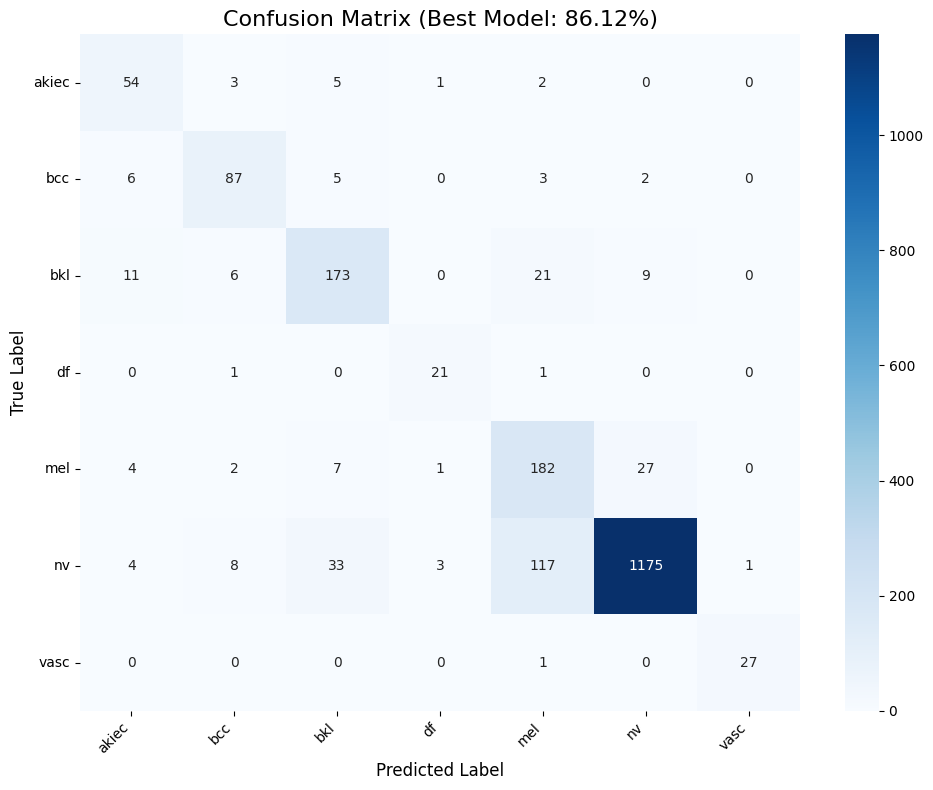


--- Step 9 Complete ---


In [ ]:
# ==================================
# 9. Testing & Visualization
# ==================================
import torch
import joblib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from transformers import BertTokenizer
from PIL import Image

# --- 1. Load Best Model and Encoder ---
print("Loading artifacts for testing...")
DRIVE_SAVE_DIR = "/content/drive/MyDrive/HAM10000_EfficientNet_ClinicalBERT_Results/"
model_save_path = os.path.join(DRIVE_SAVE_DIR, "best_multimodal_model.pth")
le_save_path = os.path.join(DRIVE_SAVE_DIR, "label_encoder.joblib")

# Load the Label Encoder
le = joblib.load(le_save_path)
class_names = le.classes_
num_classes = len(class_names)

# Re-initialize the model structure
# (Ensure Step 5's MultiModalNet class is in memory)
model = MultiModalNet(num_classes=num_classes)
# Load the saved weights from your best epoch
model.load_state_dict(torch.load(model_save_path))
model.to(device)
model.eval() # Set model to evaluation mode

# 'val_loader' should still be in memory from Step 4
if 'val_loader' not in globals():
    print("Error: val_loader not found. Please re-run Step 4.")
else:
    print("Model and data loader found. Starting evaluation...")

    # --- 2. Run Predictions on all Validation Data ---
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Testing on Validation Set"):
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(images, input_ids, attention_mask)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # --- 3. Generate Classification Report (Text) ---
    print("\n\n--- Classification Report (Best Model: 86.12%) ---")
    # This shows the precision, recall, and f1-score for each class
    report = classification_report(all_labels, all_preds, target_names=class_names)
    print(report)

    # --- 4. Generate Confusion Matrix (Graph) ---
    print("\n--- Confusion Matrix ---")
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)

    plt.title(f'Confusion Matrix (Best Model: {best_val_acc*100:.2f}%)', fontsize=16)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    # Save the graph to your drive
    plt.savefig(os.path.join(DRIVE_SAVE_DIR, "confusion_matrix.png"))
    plt.show()

print("\n--- Step 9 Complete ---")

Generating EDA plots from the full dataset...


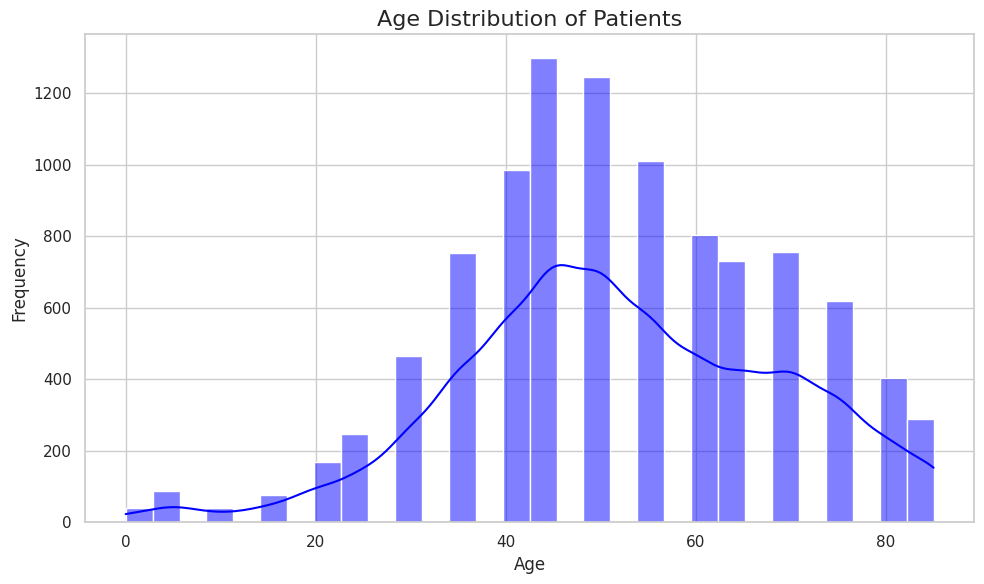

/tmp/ipython-input-4126073556.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sex', data=metadata_df, palette='viridis')


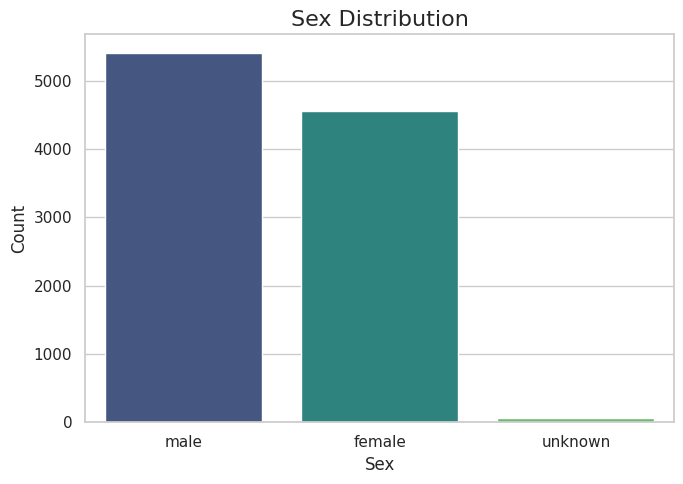

/tmp/ipython-input-4126073556.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='localization', data=metadata_df, order=order, palette='mako')


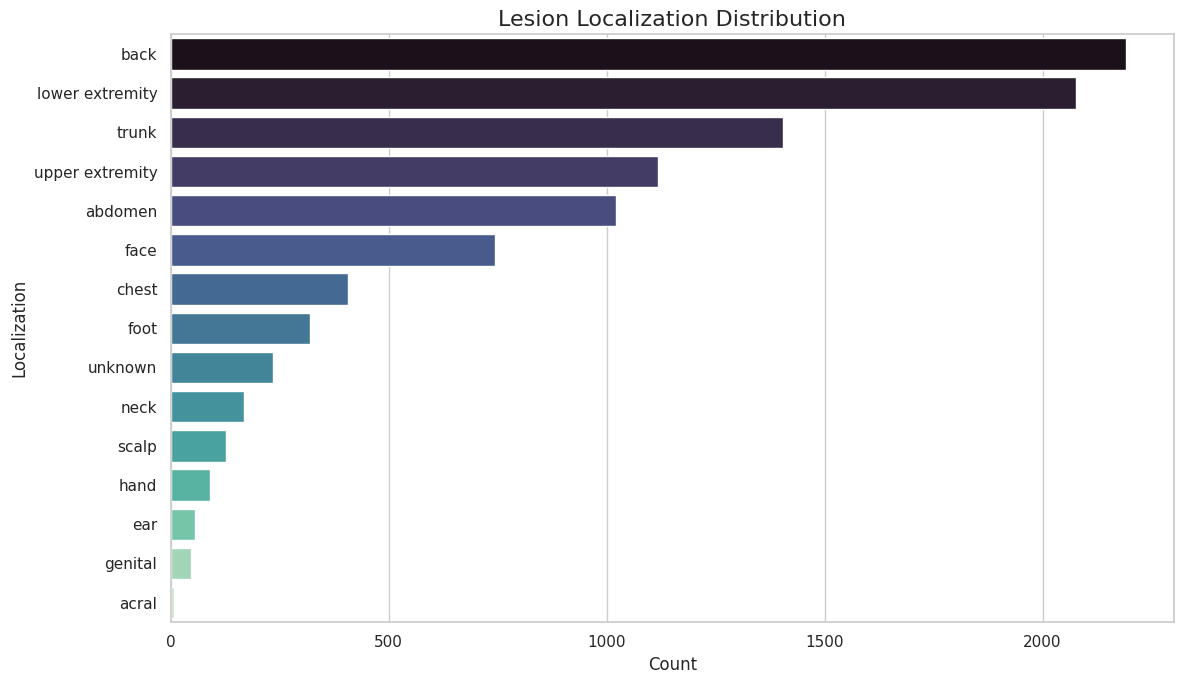


--- Step 10 Complete ---


In [ ]:
# ==================================
# 10. Data Analysis Visualization
# ==================================
import seaborn as sns
import matplotlib.pyplot as plt

# 'metadata_df' should still be in memory from Step 3
if 'metadata_df' not in globals():
    print("Error: 'metadata_df' not found. Please re-run Step 3.")
else:
    print("Generating EDA plots from the full dataset...")

    # Set the style
    sns.set(style="whitegrid")

    # --- Plot 1: Age Distribution ---
    plt.figure(figsize=(10, 6))
    sns.histplot(metadata_df['age'], bins=30, kde=True, color='blue')
    plt.title('Age Distribution of Patients', fontsize=16)
    plt.xlabel('Age', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.tight_layout()
    plt.savefig(os.path.join(DRIVE_SAVE_DIR, "age_distribution.png"))
    plt.show()

    # --- Plot 2: Sex Distribution ---
    plt.figure(figsize=(7, 5))
    sns.countplot(x='sex', data=metadata_df, palette='viridis')
    plt.title('Sex Distribution', fontsize=16)
    plt.xlabel('Sex', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.tight_layout()
    plt.savefig(os.path.join(DRIVE_SAVE_DIR, "sex_distribution.png"))
    plt.show()

    # --- Plot 3: Lesion Localization ---
    plt.figure(figsize=(12, 7))
    # Get the order of locations from most to least common
    order = metadata_df['localization'].value_counts().index
    sns.countplot(y='localization', data=metadata_df, order=order, palette='mako')
    plt.title('Lesion Localization Distribution', fontsize=16)
    plt.xlabel('Count', fontsize=12)
    plt.ylabel('Localization', fontsize=12)
    plt.tight_layout()
    plt.savefig(os.path.join(DRIVE_SAVE_DIR, "localization_distribution.png"))
    plt.show()

print("\n--- Step 10 Complete ---")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


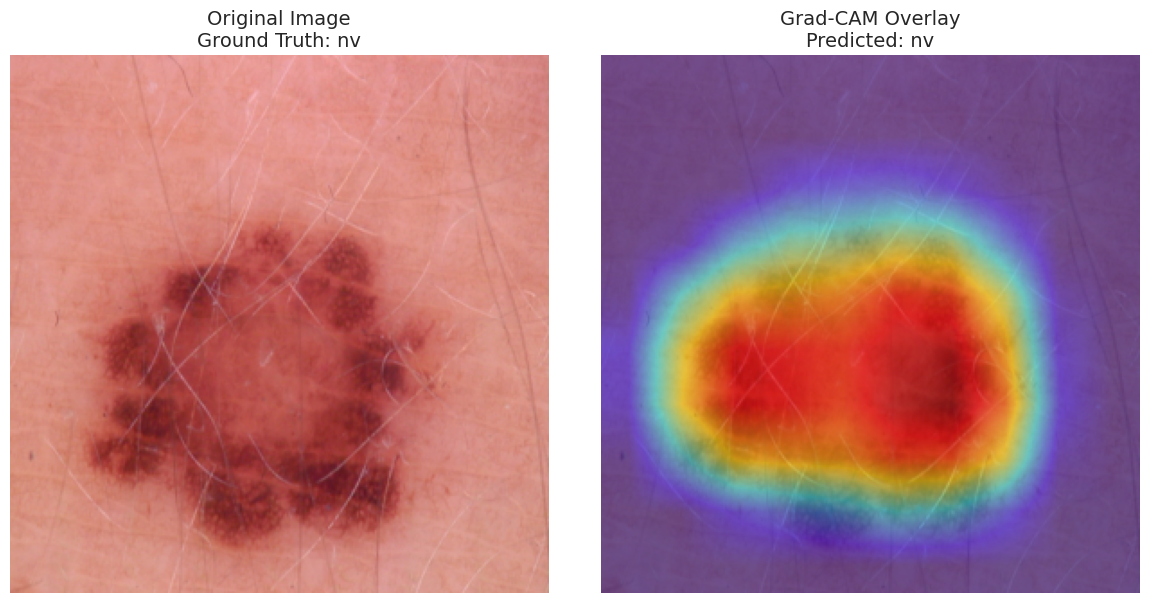


--- Step 11 Complete ---


In [ ]:
# ==================================
# 11. Grad-CAM Visualization
# ==================================
import torch.nn.functional as F
import cv2

# --- 1. Define the GradCAM Class ---
# This class is modified to hook into the model and get gradients/activations
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        def forward_hook(module, input, output):
            self.activations = output

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, image_tensor, input_ids, attention_mask, target_class=None):
        self.model.eval()

        # 1. Get model output
        output = self.model(image_tensor, input_ids, attention_mask)

        if target_class is None:
            target_class = output.argmax(1).item()

        # 2. Backpropagate
        self.model.zero_grad()
        loss = output[:, target_class]
        loss.backward()

        # 3. Get gradients and activations
        gradients = self.gradients.cpu().data.numpy()[0]
        activations = self.activations.cpu().data.numpy()[0]

        # 4. Calculate heatmap
        weights = np.mean(gradients, axis=(1, 2))
        cam = np.zeros(activations.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * activations[i, :, :]

        cam = np.maximum(cam, 0) # ReLU
        cam = cv2.resize(cam, (IMG_SIZE, IMG_SIZE))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam, target_class

# --- 2. Load a Sample and Preprocess ---
# 'val_df' should be in memory
sample = val_df.iloc[30] # <-- You can change this index!
sample_img_path = sample['image_path']
sample_text = sample['text_metadata']
ground_truth_label = class_names[sample['label']]

# We need a *single* image, not a batch
# So we create a special transform *without* augmentation
eval_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and preprocess image
image = Image.open(sample_img_path).convert('RGB')
image_tensor = eval_transforms(image).unsqueeze(0).to(device)

# Preprocess text
tokenized_text = tokenizer(
    sample_text, padding='max_length', truncation=True,
    max_length=MAX_LEN, return_tensors='pt'
)
input_ids = tokenized_text['input_ids'].to(device)
attention_mask = tokenized_text['attention_mask'].to(device)

# --- 3. Run Grad-CAM ---
# We target the final convolutional block of EfficientNet
# This is a good layer for high-level features
target_layer = model.image_model._blocks[-1]
gradcam = GradCAM(model, target_layer)

heatmap, pred_idx = gradcam.generate(image_tensor, input_ids, attention_mask)
pred_label = class_names[pred_idx]

# --- 4. Plot the Overlay ---
image_resized = image.resize((IMG_SIZE, IMG_SIZE))
image_resized = np.float32(image_resized) / 255

# Apply the heatmap
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
heatmap_colored = np.float32(heatmap_colored) / 255

# Create the overlay
overlay = 0.5 * heatmap_colored + 0.5 * image_resized
overlay = np.clip(overlay, 0, 1) # Ensure values are in [0, 1]

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(image_resized)
ax1.set_title(f"Original Image\nGround Truth: {ground_truth_label}", fontsize=14)
ax1.axis('off')

ax2.imshow(overlay)
ax2.set_title(f"Grad-CAM Overlay\nPredicted: {pred_label}", fontsize=14)
ax2.axis('off')

plt.tight_layout()
plt.savefig(os.path.join(DRIVE_SAVE_DIR, "grad_cam_example.png"))
plt.show()

print("\n--- Step 11 Complete ---")

In [ ]:
# ==================================
# 12. Final Inference & PDF Report (Stage 2)
# ==================================
import torch
import joblib
import os
import google.generativeai as genai
from google.colab import userdata
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.enums import TA_CENTER
from PIL import Image
from transformers import BertTokenizer
from torchvision import transforms

# --- 1. Load Best Model and Artifacts ---
print("Loading artifacts for final report...")
DRIVE_SAVE_DIR = "/content/drive/MyDrive/HAM10000_EfficientNet_ClinicalBERT_Results/"
model_save_path = os.path.join(DRIVE_SAVE_DIR, "best_multimodal_model.pth")
le_save_path = os.path.join(DRIVE_SAVE_DIR, "label_encoder.joblib")

# Load the Label Encoder
le = joblib.load(le_save_path)
class_names = le.classes_
num_classes = len(class_names)

# Re-initialize the model structure
# (Ensure Step 5's MultiModalNet class is in memory)
model = MultiModalNet(num_classes=num_classes)
model.load_state_dict(torch.load(model_save_path))
model.to(device)
model.eval() # Set model to evaluation mode

# Load the correct tokenizer
TOKENIZER_NAME = 'emilyalsentzer/Bio_ClinicalBERT'
tokenizer = BertTokenizer.from_pretrained(TOKENIZER_NAME)
MAX_LEN = 40
IMG_SIZE = 300

# 'val_df' should be in memory from Step 4
if 'val_df' not in globals():
    print("Error: 'val_df' not found. Please re-run Step 4.")

print("Model and encoder loaded successfully.")

# --- 2. Define Single Prediction Function ---
def predict_single_lesion(model, image_path, text_metadata, tokenizer, device, max_len):
    model.eval()

    # Define Evaluation Transforms
    eval_transforms = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # a. Preprocess Image
    image = Image.open(image_path).convert('RGB')
    image_tensor = eval_transforms(image).unsqueeze(0).to(device) # Add batch dim

    # b. Preprocess Text
    tokenized_text = tokenizer(
        text_metadata, padding='max_length', truncation=True,
        max_length=max_len, return_tensors='pt'
    )
    input_ids = tokenized_text['input_ids'].to(device)
    attention_mask = tokenized_text['attention_mask'].to(device)

    # c. Make Prediction
    with torch.no_grad():
        output = model(image_tensor, input_ids, attention_mask)
        probs = torch.softmax(output, dim=1)
        confidence, pred_idx = torch.max(probs, 1)

    return pred_idx.item(), confidence.item()

# --- 3. Run Inference on a Sample ---
# We'll use the same sample from your Grad-CAM test
sample = val_df.iloc[30] # You can change this index
sample_img_path = sample['image_path']
sample_text = sample['text_metadata']
ground_truth = sample['dx']

pred_idx, confidence = predict_single_lesion(
    model, sample_img_path, sample_text, tokenizer, device, MAX_LEN
)
pred_class_name = class_names[pred_idx]

print(f"\n--- INFERENCE REPORT ---")
print(f"  Ground Truth: {ground_truth}")
print(f"  Prediction:   {pred_class_name}")
print(f"  Confidence:   {confidence*100:.2f}%")
print(f"  Patient Data: {sample_text}")

# --- 4. Configure Gemini API ---
try:
    GOOGLE_API_KEY = userdata.get('Google_Gemini')
    genai.configure(api_key=GOOGLE_API_KEY)
    gemini_model = genai.GenerativeModel('gemini-2.5-flash')
    print("\nGemini API configured successfully.")
except Exception as e:
    print(f"\nError configuring Gemini. Please add GEMINI_API_KEY to Colab secrets. {e}")
    gemini_model = None

# --- 5. Generate Report with Gemini (Stage 2) ---
if gemini_model:
    print("Generating report with Gemini AI...")

    # This prompt is based on your PDF's requirements [cite: 49, 50, 64]
    prompt = f"""
    Generate a comprehensive, human-readable diagnostic report for a skin lesion.
    The report must be based *only* on the following AI model findings.

    AI Model Findings:
    - Predicted Diagnosis: {pred_class_name}
    - Confidence Score: {confidence*100:.2f}%
    - Patient Metadata: {sample_text}

    Report Structure:
    1.  **AI Prediction**: State the diagnosis and confidence score.
    2.  **Finding Justification**: Explain that the model based its finding on a
        multimodal analysis of both the lesion's image features and the patient's
        clinical metadata (age, sex, and location).
    3.  **About this Condition**: Give a brief, neutral, one-paragraph explanation
        of what '{pred_class_name}' is.
    4.  **Important Disclaimer**: State clearly that this is an AI-generated
        report, not a medical diagnosis, and must be reviewed by a qualified
        dermatologist.
    """

    response = gemini_model.generate_content(prompt)
    report_text = response.text

    print("\n--- Generated AI Report (from Gemini) ---")
    print(report_text)

    # --- 6. Save Report as PDF to Drive ---
    pdf_report_path = os.path.join(DRIVE_SAVE_DIR, "Patient_Diagnostic_Report.pdf")
    doc = SimpleDocTemplate(pdf_report_path, pagesize=letter)
    styles = getSampleStyleSheet()
    title_style = ParagraphStyle(name='Title', fontSize=18, alignment=TA_CENTER, spaceAfter=20)
    story = [Paragraph("AI-Assisted Skin Lesion Report", title_style)]

    # Add patient data
    story.append(Paragraph(f"<b>Patient Data:</b> {sample_text}", styles['Normal']))
    story.append(Paragraph(f"<b>Image ID:</b> {sample['image_id']}", styles['Normal']))
    story.append(Paragraph(f"<b>Ground Truth (for reference):</b> {ground_truth}", styles['Normal']))
    story.append(Spacer(1, 20))

    # Add Gemini-generated text
    for line in report_text.split('\n'):
        if line.startswith('**'):
            story.append(Paragraph(line.replace('**', ''), styles['h2']))
        else:
            story.append(Paragraph(line, styles['Normal']))

    doc.build(story)
    print(f"\nPDF report saved successfully to {pdf_report_path}")

else:
    print("\nSkipping Gemini report generation. API key not found.")

print("\n--- Project Complete ---")

Loading artifacts for final report...
Loaded pretrained weights for efficientnet-b3
Model and encoder loaded successfully.

--- INFERENCE REPORT ---
  Ground Truth: nv
  Prediction:   nv
  Confidence:   99.30%
  Patient Data: A lesion from the back of a 45 year old female.

Gemini API configured successfully.
Generating report with Gemini AI...

--- Generated AI Report (from Gemini) ---
## Skin Lesion Diagnostic Report - AI Model Analysis

**1. AI Prediction**
The AI model predicts the diagnosis of **Nevus (Common Mole)** with a high confidence score of **99.30%**.

**2. Finding Justification**
The model's prediction is based on a comprehensive multimodal analysis. This analysis considered the visual characteristics extracted from the lesion's image features, alongside the provided clinical metadata, which includes the patient's age (45 years old), sex (female), and the lesion's anatomical location (back).

**3. About this Condition**
A nevus (plural: nevi), commonly known as a mole, i

In [ ]:
# ==================================
# 12. Final Multimodal Report (Stage 2)
# ==================================
import torch
import joblib
import os
import google.generativeai as genai
from google.colab import userdata
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image, Table, TableStyle, PageBreak
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.enums import TA_CENTER
from reportlab.lib.units import inch
from PIL import Image as PILImage
from transformers import BertTokenizer
from torchvision import transforms
import torch.nn.functional as F
import cv2
import numpy as np

# --- 1. Load All Artifacts ---
print("Loading all model artifacts...")
DRIVE_SAVE_DIR = "/content/drive/MyDrive/HAM10000_EfficientNet_ClinicalBERT_Results/"
model_save_path = os.path.join(DRIVE_SAVE_DIR, "best_multimodal_model.pth")
le_save_path = os.path.join(DRIVE_SAVE_DIR, "label_encoder.joblib")

# Load Label Encoder
le = joblib.load(le_save_path)
class_names = le.classes_
num_classes = len(class_names)

# Re-initialize the model structure (ensure Step 5 is in memory)
model = MultiModalNet(num_classes=num_classes)
model.load_state_dict(torch.load(model_save_path))
model.to(device)
model.eval()

# Load Tokenizer
TOKENIZER_NAME = 'emilyalsentzer/Bio_ClinicalBERT'
tokenizer = BertTokenizer.from_pretrained(TOKENIZER_NAME)
MAX_LEN = 40
IMG_SIZE = 300

print("Model and encoder loaded successfully.")

# --- 2. Select Sample and Run Prediction ---
# 'val_df' should be in memory from Step 4
sample = val_df.iloc[30] # <-- You can change this index
sample_img_path = sample['image_path']
sample_text = sample['text_metadata']
ground_truth = sample['dx']
sample_image_id = sample['image_id']

# Define Evaluation Transforms
eval_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Preprocess image and text for prediction
image_pil = PILImage.open(sample_img_path).convert('RGB')
image_tensor = eval_transforms(image_pil).unsqueeze(0).to(device)
tokenized_text = tokenizer(
    sample_text, padding='max_length', truncation=True,
    max_length=MAX_LEN, return_tensors='pt'
)
input_ids = tokenized_text['input_ids'].to(device)
attention_mask = tokenized_text['attention_mask'].to(device)

# Run prediction
with torch.no_grad():
    output = model(image_tensor, input_ids, attention_mask)
    probs = torch.softmax(output, dim=1)
    confidence, pred_idx = torch.max(probs, 1)

pred_class_name = class_names[pred_idx.item()]
pred_confidence = confidence.item()

print(f"\n--- INFERENCE REPORT ---")
print(f"  Ground Truth: {ground_truth}")
print(f"  Prediction:   {pred_class_name} (Confidence: {pred_confidence*100:.2f}%)")
print(f"  Patient Data: {sample_text}")

# --- 3. Generate Grad-CAM for this Sample ---
print("Generating Grad-CAM...")

# (Re-using the GradCAM class from Step 11)
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()
    def hook_layers(self):
        def backward_hook(module, grad_input, grad_output): self.gradients = grad_output[0]
        def forward_hook(module, input, output): self.activations = output
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)
    def generate(self, image_tensor, input_ids, attention_mask, target_class=None):
        self.model.eval()
        output = self.model(image_tensor, input_ids, attention_mask)
        if target_class is None: target_class = output.argmax(1).item()
        self.model.zero_grad(); output[:, target_class].backward();
        gradients = self.gradients.cpu().data.numpy()[0]; activations = self.activations.cpu().data.numpy()[0]
        weights = np.mean(gradients, axis=(1, 2)); cam = np.zeros(activations.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights): cam += w * activations[i, :, :]
        cam = np.maximum(cam, 0); cam = cv2.resize(cam, (IMG_SIZE, IMG_SIZE));
        cam = cam - np.min(cam); cam = cam / np.max(cam); return cam, target_class

# Run Grad-CAM
target_layer = model.image_model._blocks[-1]
gradcam = GradCAM(model, target_layer)
heatmap, _ = gradcam.generate(image_tensor, input_ids, attention_mask, target_class=pred_idx.item())

# Create and save the overlay image
image_resized = image_pil.resize((IMG_SIZE, IMG_SIZE)); image_resized_np = np.float32(image_resized) / 255
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB); heatmap_colored_np = np.float32(heatmap_colored) / 255
overlay = 0.5 * heatmap_colored_np + 0.5 * image_resized_np
overlay = np.clip(overlay, 0, 1)

# Save the overlay to a temporary file
gradcam_save_path = os.path.join(DRIVE_SAVE_DIR, "temp_gradcam.png")
plt.imsave(gradcam_save_path, overlay)
# Save the original image to a temporary file
original_img_save_path = os.path.join(DRIVE_SAVE_DIR, "temp_original.png")
image_resized.save(original_img_save_path)

print("Grad-CAM generated and saved.")

# --- 4. Configure and Run Gemini API ---
try:
    GOOGLE_API_KEY = userdata.get('Google_Gemini')
    genai.configure(api_key=GOOGLE_API_KEY)
    gemini_model = genai.GenerativeModel('gemini-2.5-flash')
    print("\nGemini API configured successfully.")
except Exception as e:
    print(f"\nError configuring Gemini. Please add GEMINI_API_KEY to Colab secrets. {e}")
    gemini_model = None

# --- 5. Generate Report Text ---
if gemini_model:
    print("Generating report with Gemini AI...")
    prompt = f"""
    Generate a comprehensive, human-readable diagnostic report for a skin lesion.
    The report must be based *only* on the following AI model findings.

    AI Model Findings:
    - Predicted Diagnosis: {pred_class_name}
    - Confidence Score: {pred_confidence*100:.2f}%
    - Patient Metadata: {sample_text}

    Report Structure:
    1.  **AI Prediction**: State the diagnosis and confidence score.
    2.  **Finding Justification**: Explain that the model based its finding on a
        multimodal analysis of both the lesion's image features and the patient's
        clinical metadata (age, sex, and location).
    3.  **About this Condition**: Give a brief, neutral, one-paragraph explanation
        of what '{pred_class_name}' is.
    4.  **Important Disclaimer**: State clearly that this is an AI-generated
        report, not a medical diagnosis, and must be reviewed by a qualified
        dermatologist.
    """
    response = gemini_model.generate_content(prompt)
    report_text = response.text
    print("Gemini report text generated.")
else:
    print("\nSkipping Gemini report generation. API key not found.")
    report_text = "Error: Gemini API key not found. Could not generate report."

# --- 6. Build the Final PDF Report ---
print("Building final PDF report...")
pdf_report_path = os.path.join(DRIVE_SAVE_DIR, "Patient_Diagnostic_Report_FINAL.pdf")
doc = SimpleDocTemplate(pdf_report_path, pagesize=letter)
styles = getSampleStyleSheet()
story = []

# Title
title_style = ParagraphStyle(name='Title', fontSize=18, alignment=TA_CENTER, spaceAfter=20)
story.append(Paragraph("AI-Assisted Skin Lesion Report", title_style))

# Patient Info
story.append(Paragraph(f"<b>Patient Data (Text Input):</b> {sample_text}", styles['Normal']))
story.append(Paragraph(f"<b>Image ID:</b> {sample_image_id}", styles['Normal']))
story.append(Paragraph(f"<b>Ground Truth (for reference):</b> {ground_truth}", styles['Normal']))
story.append(Spacer(1, 0.25 * inch))

# --- Add Images Side-by-Side ---
img_style = ParagraphStyle(name='ImgTitle', fontSize=10, alignment=TA_CENTER)
img_original = Image(original_img_save_path, width=2.5*inch, height=2.5*inch)
img_gradcam = Image(gradcam_save_path, width=2.5*inch, height=2.5*inch)

# Create table data for images
image_table_data = [
    [img_original, img_gradcam],
    [Paragraph("Original Image (Image Input)", img_style), Paragraph("Grad-CAM Visualization (Model Focus)", img_style)]
]
image_table = Table(image_table_data, colWidths=[3*inch, 3*inch])
story.append(image_table)
story.append(Spacer(1, 0.25 * inch))

# --- Add Gemini Report Text ---
story.append(Paragraph("--- Diagnostic Explanation (Generative Output) ---", styles['h2']))
for line in report_text.split('\n'):
    if line.startswith('**'):
        story.append(Paragraph(line.replace('**', ''), styles['h3']))
    else:
        story.append(Paragraph(line, styles['Normal']))

# --- Add Appendix Page with EDA Graphs ---
story.append(PageBreak())
story.append(Paragraph("Appendix: Dataset Analysis", styles['h2']))
story.append(Paragraph("The following graphs show the data distribution the model was trained on.", styles['Normal']))
story.append(Spacer(1, 0.2 * inch))

# Load saved graphs from Drive
age_graph_path = os.path.join(DRIVE_SAVE_DIR, "age_distribution.png")
sex_graph_path = os.path.join(DRIVE_SAVE_DIR, "sex_distribution.png")
loc_graph_path = os.path.join(DRIVE_SAVE_DIR, "localization_distribution.png")

if os.path.exists(age_graph_path):
    story.append(Image(age_graph_path, width=6*inch, height=4*inch))
if os.path.exists(sex_graph_path):
    story.append(Image(sex_graph_path, width=5*inch, height=3.5*inch))
if os.path.exists(loc_graph_path):
    story.append(Image(loc_graph_path, width=7*inch, height=4.5*inch))

# Build the PDF
doc.build(story)
print(f"\nPDF report saved successfully to {pdf_report_path}")

# Clean up temporary images
os.remove(gradcam_save_path)
os.remove(original_img_save_path)

print("\n--- Project Complete ---")

Loading all model artifacts...
Loaded pretrained weights for efficientnet-b3
Model and encoder loaded successfully.

--- INFERENCE REPORT ---
  Ground Truth: nv
  Prediction:   nv (Confidence: 99.30%)
  Patient Data: A lesion from the back of a 45 year old female.
Generating Grad-CAM...
Grad-CAM generated and saved.

Gemini API configured successfully.
Generating report with Gemini AI...
Gemini report text generated.
Building final PDF report...

PDF report saved successfully to /content/drive/MyDrive/HAM10000_EfficientNet_ClinicalBERT_Results/Patient_Diagnostic_Report_FINAL.pdf

--- Project Complete ---
